# Escala de Trabalho Otimizada com Algoritmo Genético

Este notebook demonstra como criar uma API ou solução para geração de escalas de trabalho otimizadas, considerando múltiplas restrições e preferências, utilizando algoritmos genéticos.

**Objetivos:**
- Montar escalas de trabalho semanais para equipes (ex: hospital, loja, fábrica).
- Considerar restrições como carga horária máxima, folgas obrigatórias, cobertura mínima por turno, preferências e justiça na distribuição.
- Visualizar a evolução da qualidade da escala ao longo das gerações.

**Sumário:**
1. Importação das Bibliotecas Necessárias
2. Modelagem dos Dados para Escala de Trabalho
3. Definição de Restrições e Regras de Negócio
4. Função de Fitness para Avaliação das Escalas
5. Geração de Exemplos de Escalas
6. Avaliação dos Exemplos com a Função de Fitness
7. Implementação do Algoritmo Genético para Otimização da Escala
8. Visualização da Evolução do Fitness
9. Exemplo Prático de Crossover e Mutação com Restrições

## 1. Importação das Bibliotecas Necessárias

Vamos importar as bibliotecas essenciais para manipulação de dados, geração aleatória e visualização.

In [1]:
# Importação das bibliotecas
import random
import numpy as np
import matplotlib.pyplot as plt

## 2. Modelagem dos Dados para Escala de Trabalho

Vamos definir os dados básicos: funcionários, turnos, dias da semana, preferências e estrutura da escala.

In [2]:
# Funcionários
funcionarios = [
    {"id": 1, "nome": "Ana", "preferencias_folga": ["domingo"]},
    {"id": 2, "nome": "Bruno", "preferencias_folga": ["sábado"]},
    {"id": 3, "nome": "Carla", "preferencias_folga": ["segunda"]},
    {"id": 4, "nome": "Diego", "preferencias_folga": ["terça"]},
    {"id": 5, "nome": "Elisa", "preferencias_folga": ["quarta"]},
]

# Dias e turnos
semana = ["segunda", "terça", "quarta", "quinta", "sexta", "sábado", "domingo"]
turnos = ["manha", "tarde", "noite"]

# Exemplo de estrutura de escala: escala[func_id][dia][turno] = 1 (trabalha) ou 0 (folga)
# Inicialização vazia para exemplo
escala_exemplo = {
    f["id"]: {dia: {turno: 0 for turno in turnos} for dia in semana} for f in funcionarios
}

# Exemplo: Ana trabalha segunda de manhã e tarde
escala_exemplo[1]["segunda"]["manha"] = 1
escala_exemplo[1]["segunda"]["tarde"] = 1
# Bruno trabalha terça à noite
escala_exemplo[2]["terça"]["noite"] = 1

## 3. Definição de Restrições e Regras de Negócio

Vamos definir as principais restrições para a escala de trabalho:

In [3]:
# Restrições
CARGA_MAX_SEMANAL = 6  # máximo de turnos por semana por funcionário
FOLGAS_OBRIGATORIAS = 1  # mínimo de folgas por semana
COBERTURA_MINIMA = 2  # mínimo de funcionários por turno

# Função para checar restrições em uma escala
def checar_restricoes(escala, funcionarios, semana, turnos):
    violacoes = []
    # 1. Carga horária máxima e folgas obrigatórias
    for f in funcionarios:
        total_turnos = sum(escala[f["id"]][dia][turno] for dia in semana for turno in turnos)
        folgas = sum(all(escala[f["id"]][dia][t] == 0 for t in turnos) for dia in semana)
        if total_turnos > CARGA_MAX_SEMANAL:
            violacoes.append(f"{f['nome']} excedeu carga máxima semanal.")
        if folgas < FOLGAS_OBRIGATORIAS:
            violacoes.append(f"{f['nome']} não tem folgas suficientes.")
    # 2. Cobertura mínima por turno
    for dia in semana:
        for turno in turnos:
            trabalhando = sum(escala[f["id"]][dia][turno] for f in funcionarios)
            if trabalhando < COBERTURA_MINIMA:
                violacoes.append(f"Cobertura insuficiente em {dia} {turno}.")
    return violacoes

## 4. Função de Fitness para Avaliação das Escalas

A função de fitness avalia a qualidade de uma escala, penalizando violações de restrições e premiando preferências atendidas.

In [4]:
# Função de fitness

def calcular_fitness(escala, funcionarios, semana, turnos):
    score = 0
    violacoes = checar_restricoes(escala, funcionarios, semana, turnos)
    score -= 10 * len(violacoes)  # penalidade forte para cada violação
    # Preferências de folga atendidas
    for f in funcionarios:
        for dia_pref in f["preferencias_folga"]:
            if all(escala[f["id"]][dia_pref][t] == 0 for t in turnos):
                score += 2  # bônus por folga atendida
    return score, violacoes

## 5. Geração de Exemplos de Escalas

Vamos criar exemplos de escalas (válidas e inválidas) para testar a função de fitness e ilustrar diferentes cenários.

In [5]:
# Exemplo 1: Escala válida (cobertura mínima, folgas, carga horária)
escala_valida = {
    f["id"]: {dia: {turno: 0 for turno in turnos} for dia in semana} for f in funcionarios
}
# Distribuir turnos de forma justa
for i, f in enumerate(funcionarios):
    for j, dia in enumerate(semana):
        turno = turnos[(i + j) % len(turnos)]
        escala_valida[f["id"]][dia][turno] = 1

# Exemplo 2: Escala com violações (sobrecarga e falta de cobertura)
escala_invalida = {
    f["id"]: {dia: {turno: 0 for turno in turnos} for dia in semana} for f in funcionarios
}
# Um funcionário sobrecarregado, outros com folgas demais
for dia in semana:
    escala_invalida[1][dia]["manha"] = 1
    escala_invalida[1][dia]["tarde"] = 1  # Ana faz dois turnos por dia
# Cobertura insuficiente nos outros turnos

## 6. Avaliação dos Exemplos com a Função de Fitness

Vamos avaliar as escalas geradas, mostrando a pontuação de fitness e as violações de restrições.

In [6]:
# Avaliação das escalas de exemplo
for nome, escala in [("Válida", escala_valida), ("Inválida", escala_invalida)]:
    score, violacoes = calcular_fitness(escala, funcionarios, semana, turnos)
    print(f"\nEscala {nome}: Score = {score}")
    if violacoes:
        print("Violações:")
        for v in violacoes:
            print(" -", v)
    else:
        print("Sem violações!")


Escala Válida: Score = -170
Violações:
 - Ana excedeu carga máxima semanal.
 - Ana não tem folgas suficientes.
 - Bruno excedeu carga máxima semanal.
 - Bruno não tem folgas suficientes.
 - Carla excedeu carga máxima semanal.
 - Carla não tem folgas suficientes.
 - Diego excedeu carga máxima semanal.
 - Diego não tem folgas suficientes.
 - Elisa excedeu carga máxima semanal.
 - Elisa não tem folgas suficientes.
 - Cobertura insuficiente em segunda noite.
 - Cobertura insuficiente em terça manha.
 - Cobertura insuficiente em quarta tarde.
 - Cobertura insuficiente em quinta noite.
 - Cobertura insuficiente em sexta manha.
 - Cobertura insuficiente em sábado tarde.
 - Cobertura insuficiente em domingo noite.

Escala Inválida: Score = -222
Violações:
 - Ana excedeu carga máxima semanal.
 - Ana não tem folgas suficientes.
 - Cobertura insuficiente em segunda manha.
 - Cobertura insuficiente em segunda tarde.
 - Cobertura insuficiente em segunda noite.
 - Cobertura insuficiente em terça ma

## 7. Implementação do Algoritmo Genético para Otimização da Escala

Agora vamos implementar um algoritmo genético simples para buscar escalas que maximizem o fitness, respeitando as restrições.

In [38]:
# Parâmetros do algoritmo genético
USAR_ELITISMO = False  # Se True, mantém o melhor indivíduo de cada geração
POP_SIZE = 20
N_GERACOES = 40
TAXA_MUTACAO = 0.2

# Geração de indivíduo aleatório (escala)
def gerar_individuo():
    escala = {f["id"]: {dia: {turno: 0 for turno in turnos} for dia in semana} for f in funcionarios}
    for f in funcionarios:
        turnos_disponiveis = [(dia, turno) for dia in semana for turno in turnos]
        random.shuffle(turnos_disponiveis)
        # Distribuir até a carga máxima semanal
        for (dia, turno) in turnos_disponiveis[:CARGA_MAX_SEMANAL]:
            escala[f["id"]][dia][turno] = 1
    return escala

# Crossover: mistura turnos de dois pais
def crossover(pai1, pai2):
    filho = {f["id"]: {dia: {turno: 0 for turno in turnos} for dia in semana} for f in funcionarios}
    for f in funcionarios:
        for dia in semana:
            for turno in turnos:
                if random.random() < 0.5:
                    filho[f["id"]][dia][turno] = pai1[f["id"]][dia][turno]
                else:
                    filho[f["id"]][dia][turno] = pai2[f["id"]][dia][turno]
    return filho

# Mutação: troca aleatoriamente alguns turnos
def mutacao(escala):
    novo = {f["id"]: {dia: escala[f["id"]][dia].copy() for dia in semana} for f in funcionarios}
    for f in funcionarios:
        if random.random() < TAXA_MUTACAO:
            dia1, turno1 = random.choice(semana), random.choice(turnos)
            dia2, turno2 = random.choice(semana), random.choice(turnos)
            # Troca o valor dos turnos
            novo[f["id"]][dia1][turno1], novo[f["id"]][dia2][turno2] = novo[f["id"]][dia2][turno2], novo[f["id"]][dia1][turno1]
    return novo

# Algoritmo genético principal
evolucao_fitness = []
populacao = [gerar_individuo() for _ in range(POP_SIZE)]

for geracao in range(N_GERACOES):
    fitness_pop = [calcular_fitness(ind, funcionarios, semana, turnos)[0] for ind in populacao]
    selecionados = [populacao[i] for i in np.argsort(fitness_pop)[-POP_SIZE//2:]]
    nova_pop = []
    # Elitismo: mantém o melhor indivíduo
    if USAR_ELITISMO:
        melhor_idx = int(np.argmax(fitness_pop))
        nova_pop.append(populacao[melhor_idx])
    while len(nova_pop) < POP_SIZE:
        pais = random.sample(selecionados, 2)
        filho = crossover(pais[0], pais[1])
        filho = mutacao(filho)
        nova_pop.append(filho)
    populacao = nova_pop
    melhor_fitness = max(fitness_pop)
    evolucao_fitness.append(melhor_fitness)

# Melhor escala encontrada
fitness_final = [calcular_fitness(ind, funcionarios, semana, turnos)[0] for ind in populacao]
melhor_idx = int(np.argmax(fitness_final))
melhor_escala = populacao[melhor_idx]
print("\nMelhor escala encontrada (fitness):", fitness_final[melhor_idx])


Melhor escala encontrada (fitness): -32


## 8. Visualização da Evolução do Fitness

Vamos visualizar graficamente a evolução do melhor fitness ao longo das gerações.

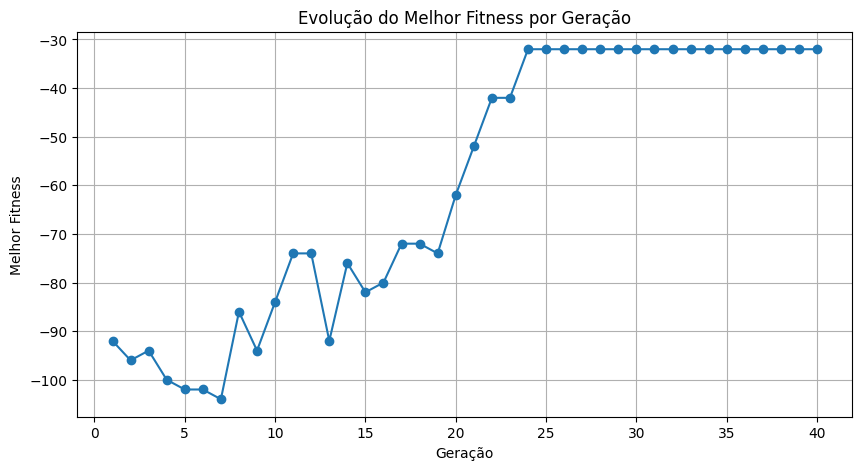

In [39]:
# Visualização da evolução do fitness
generations = list(range(1, N_GERACOES+1))
plt.figure(figsize=(10,5))
plt.plot(generations, evolucao_fitness, marker='o')
plt.title('Evolução do Melhor Fitness por Geração')
plt.xlabel('Geração')
plt.ylabel('Melhor Fitness')
plt.grid(True)
plt.show()

## 9. Exemplo Prático de Crossover e Mutação com Restrições

Vamos demonstrar como o crossover e a mutação respeitam restrições como unicidade e carga horária máxima.

In [ ]:
# Exemplo prático de crossover e mutação
pai1 = gerar_individuo()
pai2 = gerar_individuo()
print("Fitness pai1:", calcular_fitness(pai1, funcionarios, semana, turnos)[0])
print("Fitness pai2:", calcular_fitness(pai2, funcionarios, semana, turnos)[0])

filho = crossover(pai1, pai2)
filho = mutacao(filho)
score_filho, violacoes_filho = calcular_fitness(filho, funcionarios, semana, turnos)
print("\nFitness filho após crossover e mutação:", score_filho)
if violacoes_filho:
    print("Violações no filho:")
    for v in violacoes_filho:
        print(" -", v)
else:
    print("Sem violações!")